In [67]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import os, shutil
from keras.optimizers import * 
import skimage.io as io
import skimage.transform as trans
import matplotlib.image as mpimg
%matplotlib inline

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# for file in os.listdir("/content/drive/My Drive/image"):
#   if os.path.isfile(os.path.join("/content/drive/My Drive/image/", file)):
#     shutil.move(os.path.join("/content/drive/My Drive/image/", file),
                # "/content/drive/My Drive/image/train") 

In [ ]:
# for file in os.listdir("/content/drive/My Drive/label"):
#   if os.path.isfile(os.path.join("/content/drive/My Drive/label/", file)):
#     shutil.move(os.path.join("/content/drive/My Drive/label/", file),
#                 "/content/drive/My Drive/label/labels") 

In [ ]:
# shutil.rmtree("/content/gdrive/My Drive/image")
# shutil.rmtree("/content/gdrive/My Drive/label")

# Defining the model architecture &mdash; UNET

The architecture is as follows:

![UNET architecture](https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png)

According to the [research paper](https://arxiv.org/pdf/1505.04597.pdf)
where this architecture was proposed, after the downsampling section of the network there was a dropout layer included, not explicity shown in the image. Dropout helps with generalization to data, avoiding overfitting.

Data augmentation was also important to favour regularization, discussed later.

In [21]:
def unet(pretrained=False, input_size=(256,256,1)):

    
    if pretrained:
      model = keras.models.load_model("/content/drive/My Drive/model.hdf5")
      return model

    inputs = Input(shape=input_size)
    initializer = "glorot_uniform"

    """This is the downsampling feature map part"""

    conv1 = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=initializer)(inputs)
    conv2 = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(2, padding="same")(conv2) #128

    conv3 = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=initializer)(pool1)
    conv4 = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv3)
    pool2 = MaxPooling2D(2, padding="same")(conv4) #64

    conv5 = Conv2D(256, 3, padding="same", activation="relu", kernel_initializer=initializer)(pool2)
    conv6 = Conv2D(256, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv5)
    pool3 = MaxPooling2D(2, padding="same")(conv6) #32

    conv7 = Conv2D(512, 3, padding="same", activation="relu", kernel_initializer=initializer)(pool3)
    conv8 = Conv2D(512, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv7)
    pool4 = MaxPooling2D(2, padding="same")(conv8) #16

    conv9 = Conv2D(1024, 3, padding="same", activation="relu", kernel_initializer=initializer)(pool4)
    conv10 = Conv2D(1024, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv9)

    drop = Dropout(0.5)(conv10)

    """This is the upsampling feature map part"""

    upconv1 = Conv2DTranspose(512, 2, strides=(2,2), padding="same", activation="relu", kernel_initializer=initializer)(drop) #32
    concat1 = Concatenate(axis=-1)([conv8, upconv1])
    conv11 = Conv2D(512, 3, padding="same", activation="relu", kernel_initializer=initializer)(concat1)
    conv12 = Conv2D(512, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv11)

    upconv2 = Conv2DTranspose(256, 2, strides=(2,2), padding="same", activation="relu", kernel_initializer=initializer)(conv12)
    concat2 = Concatenate(axis=-1)([conv6, upconv2])
    conv12 = Conv2D(256, 3, padding="same", activation="relu", kernel_initializer=initializer)(concat2)
    conv13 = Conv2D(256, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv12)

    upconv3 = Conv2DTranspose(128, 2, strides=(2,2), padding="same", activation="relu", kernel_initializer=initializer)(conv13)
    concat3 = Concatenate(axis=-1)([conv4, upconv3])
    conv13 = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=initializer)(concat3)
    conv14 = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv13)

    upconv4 = Conv2DTranspose(64, 2, strides=(2,2), padding="same", activation="relu", kernel_initializer=initializer)(conv14)
    concat4 = Concatenate(axis=-1)([conv2, upconv4])
    conv15 = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=initializer)(concat4)
    conv16 = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=initializer)(conv15)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid", kernel_initializer=initializer)(conv16)


    model = Model(inputs, outputs)

    return model 

<h1>Processing the dataset &mdash; Data Augmentation</h1>

The original dataset comprised of .tif files of all masks and images, found [here](http://brainiac2.mit.edu/isbi_challenge/home). Preprocessing the images into keras-friendly form was done with help from [zhixuhao's repo](https://github.com/zhixuhao/unet). His code provided me with all the image processing required for the train and test generators, also with data augmentation.

Data augmentation was essential, the dataset contained only thirty train images, whereas the model has approximately thirty-one million parameters. Data Augmentation was important to avoid overfitting, alongside dropout.



In [22]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

In [23]:
data_gen_args = dict(featurewise_center=False,
                    featurewise_std_normalization=False,
                    width_shift_range=0.08,
                    height_shift_range=0.08,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode="nearest")

def trainGenerator(data_aug_dict, seed, train_dir, aug_dir, save_image_prefix,
                   save_mask_prefix, img_dir, mask_dir, flag_multi_class,
                   num_class, class_mode):

    image_datagen = ImageDataGenerator(**data_aug_dict)
    mask_datagen = ImageDataGenerator(**data_aug_dict)
    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = seed
    image_generator = image_datagen.flow_from_directory(
        train_dir,
        classes=[img_dir],
        class_mode=class_mode,
        seed=seed,
        save_to_dir=aug_dir,
        save_prefix=save_image_prefix,
        target_size=(256,256),
        batch_size=20,
        color_mode="grayscale")
    mask_generator = mask_datagen.flow_from_directory(
        train_dir,
        classes=[mask_dir],
        class_mode=class_mode,
        seed=seed,
        save_to_dir=aug_dir,
        save_prefix=save_mask_prefix,
        target_size=(256,256),
        batch_size=20,
        color_mode="grayscale")
    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
      img, mask = adjustData(img, mask, flag_multi_class, num_class)
      yield (img, mask)

def testGenerator(path, num_image=30, target_size=(256,256),
                  flag_multi_class=False, as_gray=True):
  
    for i in range(num_image):
        img = io.imread(os.path.join(path, f"{i}.png"), as_gray=as_gray)
        img = img/255
        img = trans.resize(img, target_size)
        img = np.reshape(img, img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img, (1,)+img.shape)
        yield img    

In [24]:
train_gen = trainGenerator(data_gen_args, 147, "/content/drive/My Drive/train/",
                           "/content/drive/My Drive/train/augmented",
                           "image", "mask", "image",
                           "label", False, 2, None)

In [25]:
def generate_batches(num_batches):
    """This function is used to generate batches of augmented data. 
       Images per batch is defined in the train generator function.

       Images generated = batch_size * num_batches 

       This function also breaks the generators infinte loop after specified
       number of batches
    """    
    
    for i,batch in enumerate(train_gen):
        if(i >= num_batch):
            break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


I defined a learning rate scheduler after trying out some values myself. Initially, I wanted the learning rate to be high `lr = 0.002` for 2 epochs. Then, as the loss started to converge, I reduced it to `lr = 0.001`.

I also saved the best model.

In [32]:
def lr_scheduler(epoch, lr):
  if epoch <= 2:
    lr = 0.002
    return lr
  lr = 0.001  
  return lr   

chkp = keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/model.hdf5",
    monitor="loss",
    verbose=1,
    save_best_only=True,
    mode="min",
)

dynamic_lr = LearningRateScheduler(lr_scheduler, verbose=1)  

In [33]:
model = unet(pretrained=False)

model.compile(optimizer=Adam(0.005), loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=5,
                              callbacks=[dynamic_lr, chkp])

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.002.
500/500 [==============================] - 776s 2s/step - loss: 0.2299 - accuracy: 0.8976

Epoch 00001: loss improved from inf to 0.22981, saving model to /content/drive/My Drive/model.hdf5
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.002.
500/500 [==============================] - 768s 2s/step - loss: 0.1176 - accuracy: 0.9484

Epoch 00002: loss improved from 0.22981 to 0.11768, saving model to /content/drive/My Drive/model.hdf5
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.002.
500/500 [==============================] - 768s 2s/step - loss: 0.0909 - accuracy: 0.9602

Epoch 00003: loss improved from 0.11768 to 0.09095, saving model to /content/drive/My Drive/model.hdf5
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
500/500 [==============================] - 768s 2s/step - loss: 0.0774 - accuracy: 0.9662

Epoch 00004: loss i

Now that the model is trained on the training images, I created a test generator. This generator would be fit in `model.predict_generator()` to make predicts on the test set.

Thanks to zhixuhao's helper functions, I was able to saved all the predicted masks in the test directory. I later defined a function that would display a test image and its corresponding predicted mask.

In [36]:
test_gen = testGenerator(path="/content/drive/My Drive/test", 
                         num_image=30, target_size=(256, 256),
                         as_gray=True)

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class, COLOR_DICT, item) if flag_multi_class else item[:, :, 0]
        io.imsave(os.path.join(save_path, f"{i}_predict.png"), img)

In [38]:
# preds = model.predict_generator(generator=test_gen, steps=30, verbose=1)
saveResult("/content/drive/My Drive/test", preds)

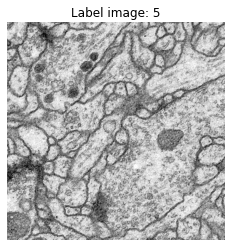

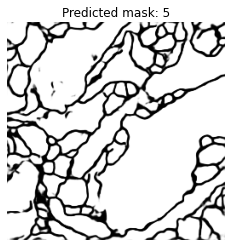

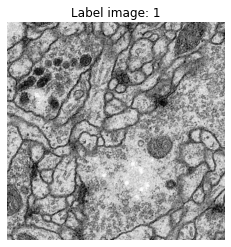

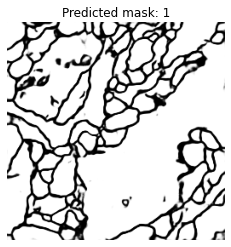

In [71]:
def plot_preds(parent_path, num_images):

    """Shows randomly selected images from test set and displays its predicted
       masks"""

    for i, _ in enumerate(parent_path):
        if i < num_images:
            randint = np.random.randint(0, 31)

            img = mpimg.imread(parent_path + f'{randint}.png')
            imgplot = plt.imshow(img, cmap="Greys_r", )
            plt.axis(False)
            plt.title(f"Label image: {randint}")
            plt.show()

            img = mpimg.imread(parent_path + f'{randint}_predict.png')
            imgplot = plt.imshow(img, cmap="binary_r")
            plt.axis(False)
            plt.title(f"Predicted mask: {randint}")
            plt.show()

plot_preds("/content/drive/My Drive/test/", 2)


In [74]:
!zip -r "/content/test.zip" "/content/drive/My Drive/test"

updating: content/drive/My Drive/test/ (stored 0%)
updating: content/drive/My Drive/test/26.png (deflated 0%)
updating: content/drive/My Drive/test/19.png (deflated 0%)
updating: content/drive/My Drive/test/25.png (deflated 0%)
updating: content/drive/My Drive/test/0.png (deflated 0%)
updating: content/drive/My Drive/test/1.png (deflated 0%)
updating: content/drive/My Drive/test/29.png (deflated 0%)
updating: content/drive/My Drive/test/12.png (deflated 0%)
updating: content/drive/My Drive/test/20.png (deflated 0%)
updating: content/drive/My Drive/test/7.png (deflated 0%)
updating: content/drive/My Drive/test/28.png (deflated 0%)
updating: content/drive/My Drive/test/17.png (deflated 0%)
updating: content/drive/My Drive/test/18.png (deflated 0%)
updating: content/drive/My Drive/test/16.png (deflated 0%)
updating: content/drive/My Drive/test/27.png (deflated 0%)
updating: content/drive/My Drive/test/23.png (deflated 0%)
updating: content/drive/My Drive/test/8.png (deflated 0%)
updating: